# Импорт библиотек

In [37]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import pandas as pd
import warnings 
from glob import glob
import os
import math
import functools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy import linalg as LA
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib as mpl

### Отключим предупреждения Anaconda

In [3]:
warnings.simplefilter('ignore')

# Загрузим данные

In [47]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/X_new.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/y.pkl.gz', 'rb'))

# N-PLS1
## Приближение к правильному алгоритму
### Опишу ка я центрирование в виде класса, для удобства.

In [5]:
import  subprocess
import sys
import os
from N_PLS1_help_scripts.CenteringClass import centrir

In [6]:
t=centrir()

In [7]:
a=t.centering_and_cv(Xdata_numpy['X'],Ydata)

In [8]:
a.y_test

array([ -8.58399134,   2.1530446 , -13.79718301,   7.44718265,
         4.40507881])

In [9]:
a.y_train

array([ -3.88210493,  -4.29886423,  -1.37197484,   7.58267641,
        16.05197918,  -3.76842976,  -5.80157011,  13.72131031,
         4.05467602,   6.32746173,   4.55217322,   2.44997086,
       -18.58347562,  -0.09283701,  -4.64005226,  -4.59584285,
        -4.27022686,  -6.65260834, -11.81077856,   3.27807984,
        -0.15706949,  -3.5147186 ,   5.45213345,   9.41508832,
        -5.7521935 ,  14.64600637,  -3.08549775,   1.0451428 ,
         8.0015989 ,  -5.9241844 ])

In [10]:
X_setting=Xdata_numpy['X'][:,15:85,:15]

In [11]:
X_setting-= X_setting.mean(axis = 0)

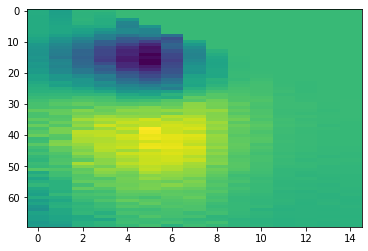

In [12]:
plt.imshow(X_setting[5,:,:], aspect='auto')
plt.show();

In [154]:
class Tri_PLS1_grid(RegressorMixin,BaseEstimator):
    def  __init__(self, n_components=2,a=3):
        self.n_components = n_components
        self.a=a
        
            
    def fit(self, xx, yy):
        """Fits the model to the data (X, y)

        Parameters
        ----------
        X : ndarray
        y : 1D-array of shape (n_samples, )
            labels associated with each sample"""
        x=xx.copy()
        y=yy.copy()        
        Tt=np.zeros([x.shape[0],self.n_components])
        mass=np.zeros([y.shape[0]])
        y_copy=yy.copy()
        """"
        При различных способах разрезания исходных данных, массивы w_k и w_i имеют похожие значения и именно их я планирую 
        использовать для функции predict данного класса. """
        w_k_mass=np.zeros([self.n_components,x.shape[1],1])
        w_i_mass=np.zeros([self.n_components,x.shape[2],1])
        bf_array=[]
        
        mmas=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
        z_pz=np.eye(x.shape[1])
        z_z=z_pz[:,:x.shape[2]]
        
        for f in range(0,self.n_components):
            z=np.zeros([x.shape[1],x.shape[2]])
            x_product=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
            
            for i in range(0,x.shape[0]):
                x_product[i,:,:]=y[i]*x[i,:,:]
            z=x_product.sum(axis=0)
            
            # Блок регуляризации z
            #z_po=LA.pinv(z)
            #z=np.dot((np.dot(z,z_po)+(self.a*np.eye(z.shape[0]))),z)
            
            
            Wk, S, WI = np.linalg.svd(z)
            #plt.imshow(Wk, aspect='auto')
            #plt.imshow(WI, aspect='auto')
            #plt.imshow(S, aspect='auto')
            #plt.show();
            w_k=np.array(Wk[:,0]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            w_k_mass[f,:,:]=w_k
            w_i_mass[f,:,:]=w_i
            
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_i.transpose(),x[h,:,:].transpose()),w_k)
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)        
            #print(T)
            #print((np.dot(np.linalg.inv(np.dot(T,T.transpose())+(self.a*np.eye(x.shape[0]))),T)).shape)
            
            
            
            bf=np.dot((np.dot(np.linalg.inv(np.dot(T,T.transpose())-(((self.a/(10*f+1)))*np.eye(x.shape[0]))),T)).transpose(),
                          y.reshape([x.shape[0],1]))
            #print(bf.shape) (self.a/(f+1)
            #print((np.dot(T,bf)).shape).reshape(x.shape[1],x.shape[2])
            bf_array+=[bf]
            #plt.plot(bf)
            #plt.show();
            
            WW=np.kron(w_k,w_i).reshape(x.shape[1],x.shape[2])
            for g in range(0,x.shape[0]):
                mmas[g,:,:]=Tt[g,f]*WW
            #mmas=np.kron(Tt[:,f],WW).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=np.array(x-(mmas)) 
            #plt.imshow(mmas[5,:,:], aspect='auto')
            #plt.show();
            #for g in range(0,x.shape[0]):
            
            #plt.imshow(np.kron(w_k,w_i).reshape(x.shape[1],x.shape[2]), aspect='auto')
            #plt.show();
            
            Y_m=(np.dot(T,bf)).reshape(x.shape[0])
            #plt.plot(Y_m, color="red")
            #plt.plot(y_copy, color="blue")
            
            y=(y-(np.dot(T,bf)).reshape(x.shape[0]))
            
            #plt.plot(y, color="green")
    
            #print(y)
            mass+=(np.dot(T,bf)).reshape(x.shape[0]).reshape(x.shape[0])
            #plt.plot(mass, color="yellow")
            #plt.show();
            bf=0
            
        self.bf_array=bf_array
        self.train_error=mean_squared_error(mass,y_copy)
        self.w_k=w_k_mass
        self.w_i=w_i_mass
        
        return self
    
    #def fit_transform(self,x.copy()):
        """"
        Даже для 20 компонент функция fit работает быстро, а вот функция predict нет.
        Кроме того, некоторые вычислительные операции требуют колоссальных 
        объёмов памяти, поэтому, сначала нужно провести анализ нагрузок и 
        трансформацию данных в форму поменьше.
        
        Отбор длин волн я решил делать при помощи поглощающих жадных алгоритмов поиска. SBS алгоритм.
        """
    
    def predict(self, xx):
        x=xx.copy()
        Tt=np.zeros([x.shape[0],self.n_components])
        #y=np.random.normal(loc=0,scale=10,size=x.shape[0])
        y=np.zeros([x.shape[0]])
        mmas=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
        for f in range(0,self.n_components):
            w_k=self.w_k[f,:,:]
            w_i=self.w_i[f,:,:]
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_i.transpose(),x[h,:,:].transpose()),w_k)
            
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            #bf=np.dot((np.dot(np.linalg.inv(np.dot(T,T.transpose())),T)).transpose(),
            #              y.reshape([x.shape[0],1]))
            WW=np.kron(w_k,w_i).reshape(x.shape[1],x.shape[2])
            #plt.imshow(WW, aspect='auto')
            #plt.show();
            for g in range(0,x.shape[0]):
                #mmas[g,:,:]=Tt[g,f]*WW
                mmas[g,:,:]=Tt[g,f]*WW
            x=np.array(x-(mmas))
            #print(len(np.kron(Tt[:,f],np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2]))))
            #print()
            #plt.plot(self.bf_array[f])
            #plt.show();
            
            #bf=np.dot((np.dot(np.linalg.inv(np.dot(T,T.transpose())-(self.a*np.eye(x.shape[0]))),T)).transpose(),
             #             y.reshape([x.shape[0],1]))
            
            y=(y+(np.dot(T,self.bf_array[f])).reshape(x.shape[0]))
            #y=(y+(np.dot(T,bf)).reshape(x.shape[0]))
        
        return y
            
            
    

# Делаю новый управляемый решётчатый поиск

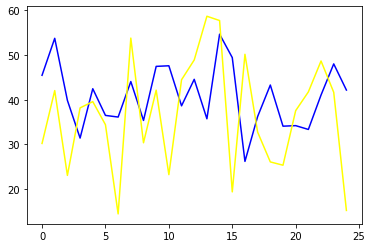

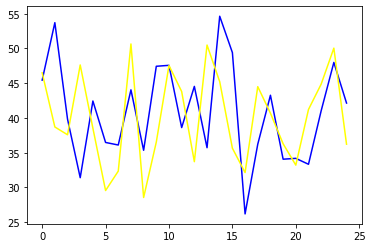

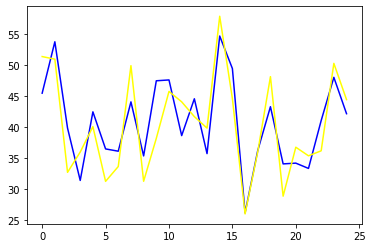

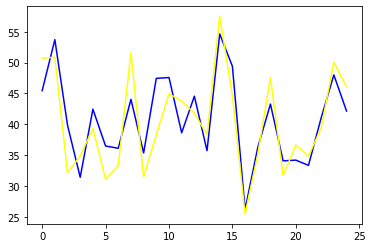

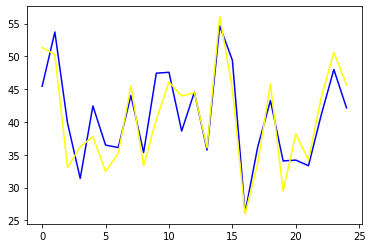

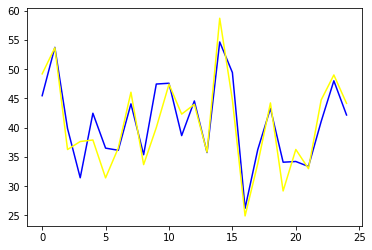

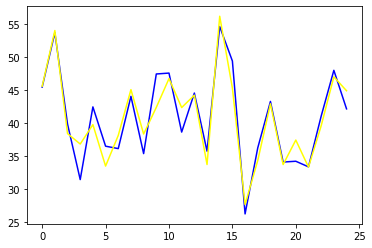

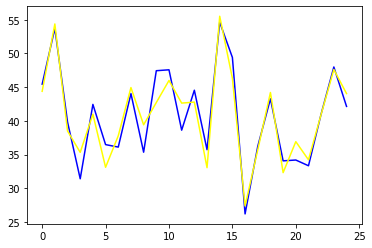

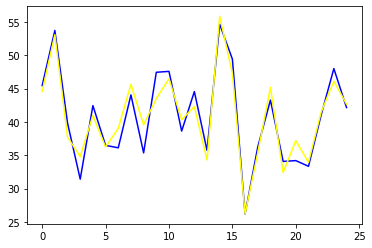

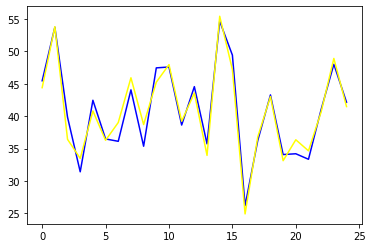

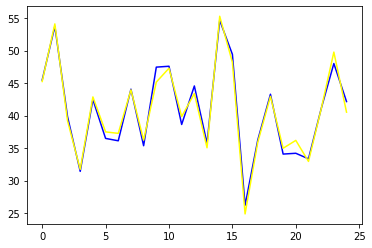

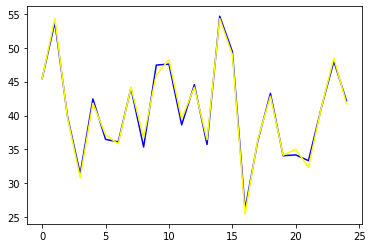

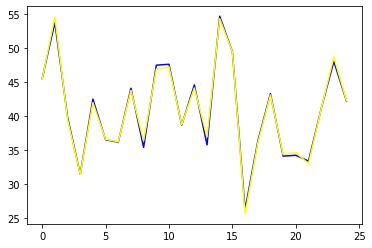

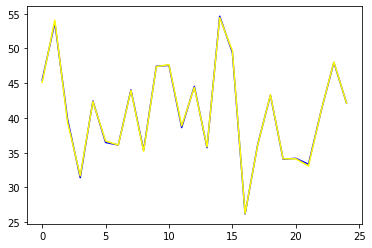

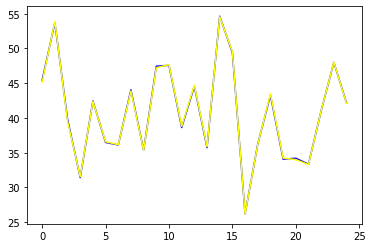

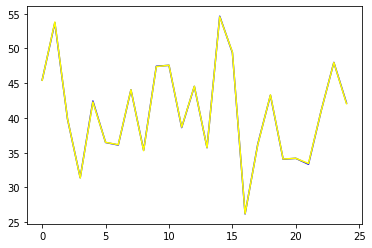

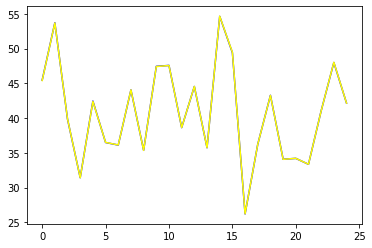

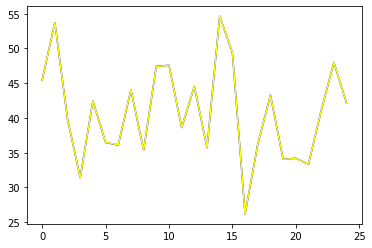

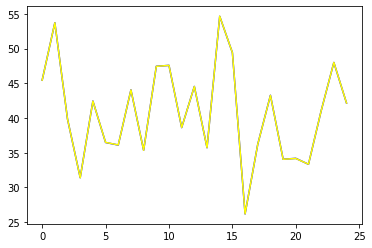

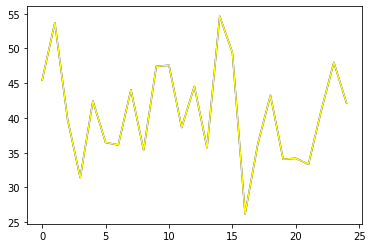

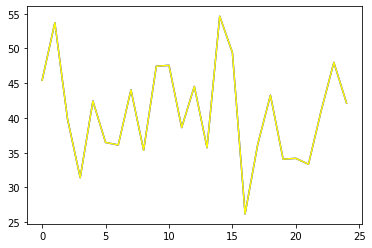

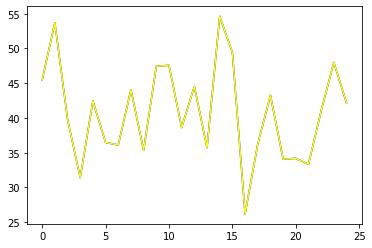

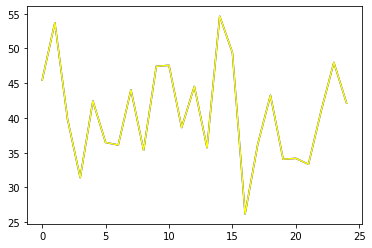

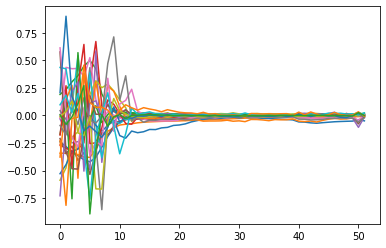

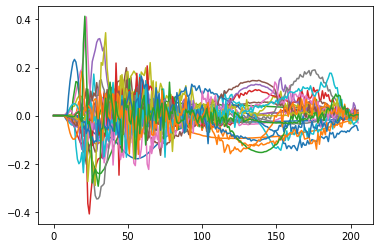

In [148]:
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])
# для гуминовых веществ может иметь смысл взять чуть больше компонент;
# для аминокислот должно быть достаточно одного
model = Tri_PLS1_grid(n_components=23, a=0.09)

# NB: здесь мы ничего не центрируем, что как будто не влияет на результат
X = Xdata_numpy['X']
#X=X_setting.copy()
#X -= X.mean(axis = 0) # раскомментировать для центрирования по X

y0 = Ydata.to_numpy()[:,0] # здесь номер колонки выбирает гуминовые вещества / тирозин / триптофан

st=np.std(y0)
#y0 -= y0.mean() # раскомментировать для центрирования по 
#y0 /= (st**2)
model.fit(X[:25,:,:], y0[:25])

# почему-то массивы w_i, w_k оказываются трёхмерными, но последняя размерность всегда 1
# уберём её, чтобы работать, как мы обычно работаем с матрицами
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])

plt.figure()
plt.plot(flatten(model.w_i).transpose())

plt.figure()
plt.plot(flatten(model.w_k).transpose())



In [171]:
y_=model.predict(10*X[25:,:,:])

In [172]:
model.score(10*X[25:,:,:],10*y0[25:])

0.7765356994950969

In [173]:
y_

array([-31.85397604,  -8.01991244, -61.78440583, -86.32145673,
        64.59338661,  52.98363407,  11.25726269, 102.4964932 ,
       -51.23770416, -13.81447933])

In [174]:
10*y0[20:]

array([ -58.01570114,  -66.52608338,   10.45142796,   80.01598899,
         21.53044598,  -57.52193498,  -30.85497753, -118.10778555,
       -185.83475616,   63.27461735,   44.05078807,   -0.92837011,
        160.51979183,  -45.95842854,  -42.98864231])

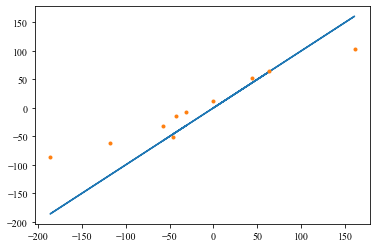

In [175]:
plt.plot(10*y0[25:],10*y0[25:])
plt.plot(10*y0[25:],y_,".")
plt.show();

# Дальше не смотреть. Ничего свежего там нет

# Центрируем данные (замена: вместо 3-х методов теперь 2)

In [103]:
cen=centrir(testSize=0.1428,column_y=0)

In [104]:
result=cen.centering_and_cv(Xdata_numpy['X'],Ydata)

In [105]:
y_train=result.y_train
y_test=result.y_test
X_train=result.X_train
X_test=result.X_test

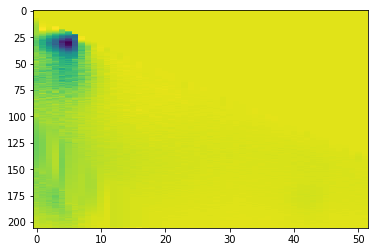

In [106]:
plt.imshow(X_train[4,:,:],aspect='auto')
plt.show()

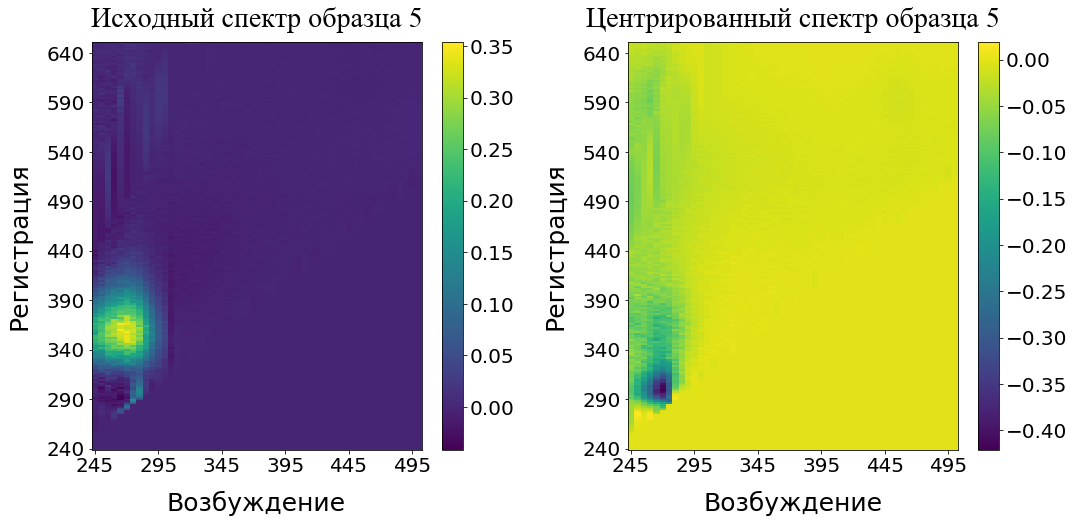

In [41]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(17, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.3, hspace=0)

fig_ax_1 = fg.add_subplot(gs[0, 0])
plt.imshow(Xdata_numpy['X'][4,:,:],aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Исходный спектр образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(195,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_2 = fg.add_subplot(gs[0, 1])
plt.imshow(X_train[4,:,:],aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Центрированный спектр образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_2.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_2.set_xticklabels(range(195,520,50), fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.savefig('centering.png', format='png', dpi=300)
plt.savefig("centering.svg", format="svg")

plt.show();

In [65]:
?plt.title

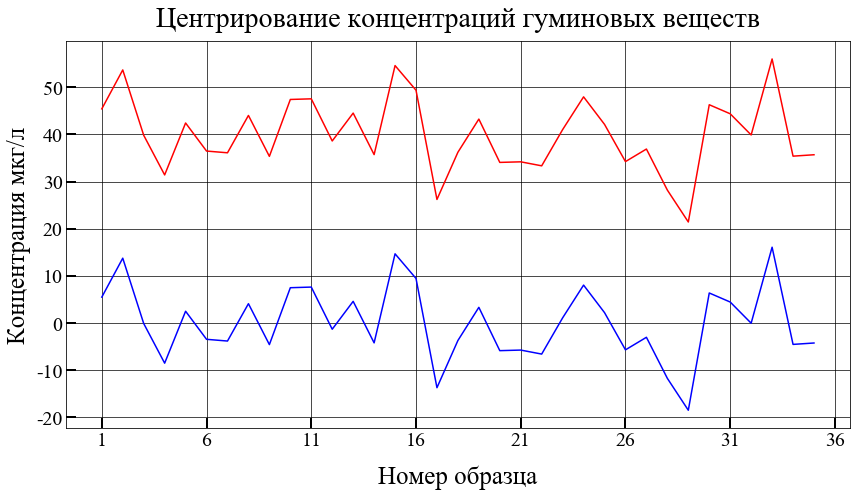

In [83]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(Ydata.iloc[:,0],"-",color="red",ms=20)
axs.plot(Ydata.iloc[:,0].to_numpy()-Ydata.iloc[:,0].to_numpy().mean(),"-",color="blue",ms=20)


#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))

axs.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Номер образца",  fontsize=25,labelpad=15)
axs.set_title("Центрирование концентраций гуминовых веществ", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(-4,42,5), fontsize=20)
axs.set_yticklabels(range(-30,60,10), fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
#axs.legend(loc=4,fontsize=20, markerscale=1,handletextpad=0)

#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('Центрирование концентраций гуминовых веществ.png', format='png', dpi=300)
plt.savefig("Центрирование концентраций гуминовых веществ.svg", format="svg")


plt.show();

In [769]:
y_test=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['y_test']
y_train=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['y_train']
X_train=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['X_train']
X_test=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['X_test']

# Делаем применение сразу по всем компонентам

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, make_scorer
import sklearn

In [149]:
from sklearn.model_selection import train_test_split
y0 = Ydata.to_numpy()[:,2]
X_train, X_test, y_train, y_test = train_test_split(
    Xdata_numpy['X'], y0, test_size=0.1428, random_state=42)

In [150]:
y0

array([1.65895884, 2.90884316, 1.09367965, 2.4133796 , 2.82216814,
       3.82666788, 0.70069367, 3.16362488, 2.1952683 , 4.01152098,
       1.00830513, 3.53356972, 4.21509135, 4.15072599, 3.67902481,
       0.84723773, 4.3136431 , 1.89912472, 1.32654998, 1.98598412,
       3.4095809 , 3.50442503, 3.84149553, 3.26700972, 0.7432221 ,
       2.29531013, 2.59334822, 1.21436859, 1.76173781, 1.44590949,
       1.50729939, 2.73793973, 2.04340843, 2.49429935, 3.07337527])

In [158]:
npls1=Tri_PLS1_grid()
scoring={'mse': make_scorer(mean_squared_error),'r2':'r2'}
parametrsNames={'n_components': range(1,37),
                'a': [0.09]}

In [159]:
%%time
gridCought=GridSearchCV(npls1, parametrsNames, cv=5, scoring=scoring,refit='r2', return_train_score=True)
gridCought.fit(X_train.copy(),y_train.copy())
r2_p=gridCought.score(X_test.copy(), y_test.copy())
mse_cv=gridCought.cv_results_[ "mean_test_mse" ]
mse_c=gridCought.cv_results_[ "mean_train_mse" ]
r2_cv=gridCought.cv_results_[ "mean_test_r2" ]
r2_c=gridCought.cv_results_[ "mean_train_r2" ]
predictors=gridCought.predict(X_test.copy())

Wall time: 1min 29s


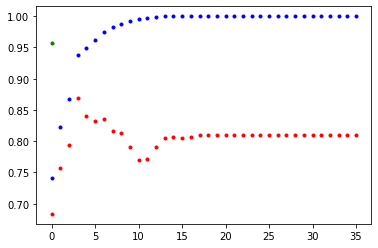

In [160]:
plt.plot(r2_p,".",color='green')
plt.plot(r2_c,".",color='blue')
plt.plot(r2_cv,".",color='red')
plt.show()

In [142]:
max(r2_c)

0.999671685137702

In [143]:
max(r2_cv)

0.5653355135388646

In [92]:
r2_cv[-1]

-0.10467465523281833

In [86]:
mse_cv

array([156.98736489,  72.10981779,  23.3943777 ,  29.38198601,
        38.80622751,  33.99437696,  27.84935082,  25.98631831,
        26.25255445,  33.53378232,  39.37478071,  45.49351442,
        45.24959053,  47.85891285,  47.34191628,  47.10221761])

In [316]:
min(mse_cv**0.5)

0.26035695639620177

In [126]:
ff={'r':r2_cv, 'mse':mse_cv**0.5}

In [197]:
r2_cv=ff['r']
mse_cv=ff['mse']**2

In [57]:
y_test

array([ 2.1530446 , -4.27022686,  2.44997086, 14.64600637, -3.88210493])

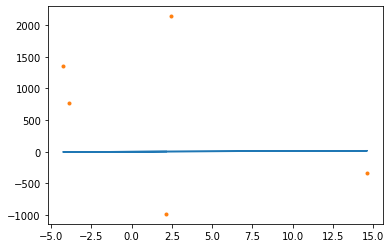

In [59]:
plt.plot(y_test,y_test)
plt.plot(y_test,predictors,".")
plt.show();

In [24]:
b_npls1_full=gridCought.best_estimator_.b.reshape(206,55)

AttributeError: 'Tri_PLS1_grid' object has no attribute 'b'

In [25]:
gridCought.best_estimator_.w_i.shape

(3, 52, 1)

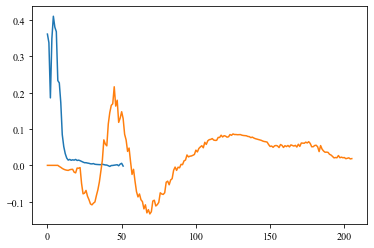

In [227]:
plt.plot(flatten(gridCought.best_estimator_.w_i)[3,:])
plt.plot(flatten(gridCought.best_estimator_.w_k)[3,:])
plt.show();

In [155]:
w_i=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Humic_N-PLS1_final_2_components.pkl.gz', 'rb'))['w_i_best_estimator']
w_k=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Humic_N-PLS1_final_2_components.pkl.gz', 'rb'))['w_k_best_estimator']

In [146]:
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])

In [192]:
w_i.shape

NameError: name 'w_i' is not defined

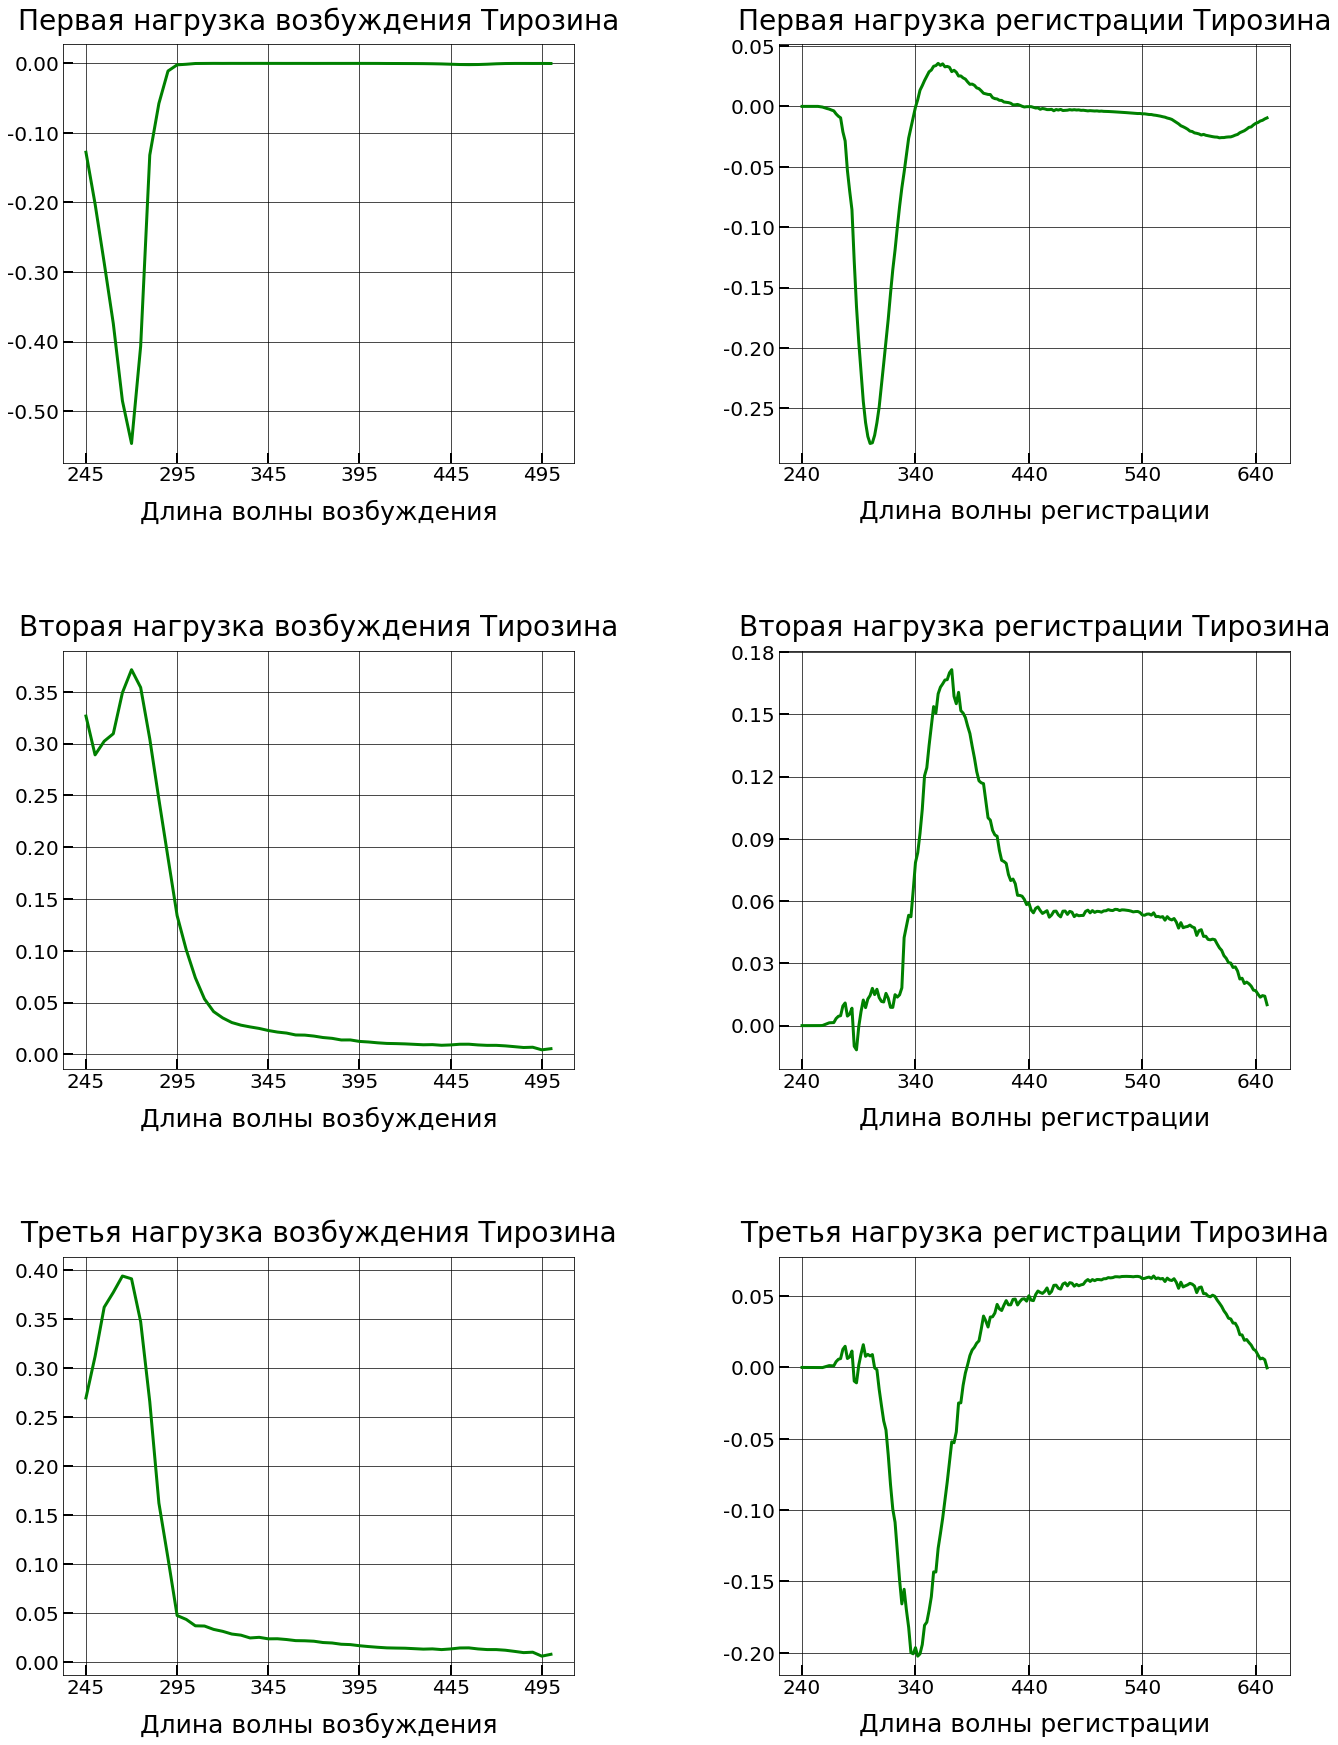

In [37]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(22, 30),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.4, hspace=0.45)

fig_ax_1 = fg.add_subplot(gs[0,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,0],"-",color="green",lw=3,label="1-st")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#fig_ax_1.set_yticks(np.linspace(-0.40, 0.0, num = 5))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Первая нагрузка возбуждения Тирозина", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels(range(195,560,50), fontsize=20)
fig_ax_1.set_yticklabels(['r','-0.50','-0.40','-0.30','-0.20','-0.10','0.00','0.10','0.20','0.1','0.2','0.3','0.4'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран

fig_ax_1 = fg.add_subplot(gs[1,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,1],"-",color="green",lw=3,label="2-nd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Вторая нагрузка возбуждения Тирозина", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels(range(195,560,50), fontsize=20)
fig_ax_1.set_yticklabels(['-0.20','0.00','0.05','0.10','0.15','0.20','0.25','0.30','0.35','0.50','0.4'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран

fig_ax_1 = fg.add_subplot(gs[2,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,2],"-",color="green",lw=3,label="3-rd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Третья нагрузка возбуждения Тирозина", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels(range(195,560,50), fontsize=20)
fig_ax_1.set_yticklabels(['-0.20','0.00','0.05','0.10','0.15','0.20','0.25','0.30','0.35','0.40','0.4'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран






fig_ax_2 = fg.add_subplot(gs[0, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,0],"-",color="green",lw=3,label="1-st")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#fig_ax_2.set_yticks(np.linspace(-0.15, 0.1, num = 6))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Первая нагрузка регистрации Тирозина", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['u','-0.25','-0.20','-0.15','-0.10','-0.05','0.00','0.05','0.10','0.2','1.0','9'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран


fig_ax_2 = fg.add_subplot(gs[1, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,1],"-",color="green",lw=3,label="2-nd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
fig_ax_2.set_yticks(np.linspace(0.0, 0.18, num = 7))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Вторая нагрузка регистрации Тирозина", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['0.00','0.03','0.06','0.09','0.12','0.15','0.18','0.2','1.0','9'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран

fig_ax_2 = fg.add_subplot(gs[2, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,2],"-",color="green",lw=3,label="3-rd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Третья нагрузка регистрации Тирозина", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['5','-0.20','-0.15','-0.10','-0.05','0.00','0.05','0.25','0.3'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран






plt.savefig('Tyr_N-PLS1_loading_3_components.png', format='png', dpi=300)
plt.savefig("Tyr_N-PLS1_loading_3_components.svg", format="svg")

plt.show();

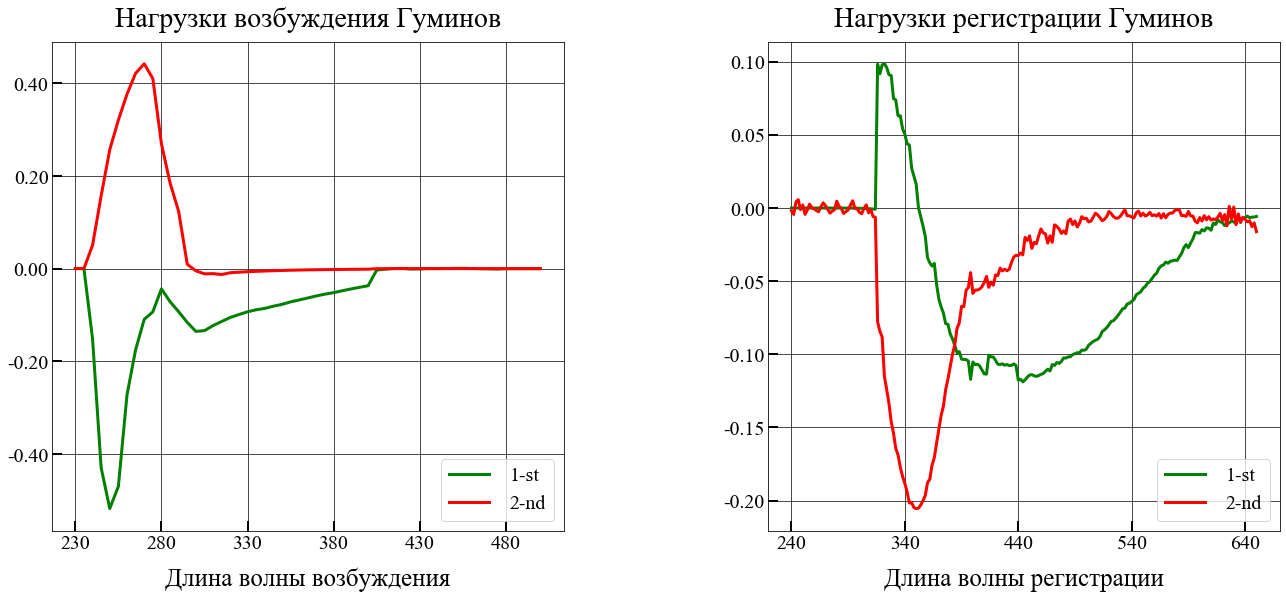

In [167]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(22, 9),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.4, hspace=0.45)

fig_ax_1 = fg.add_subplot(gs[0,0])
fig_ax_1.plot(flatten(w_i).transpose()[:,0],"-",color="green",lw=3,label="1-st")
fig_ax_1.plot(flatten(w_i).transpose()[:,1],"-",color="red",lw=3,label="2-nd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Нагрузки возбуждения Гуминов", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels(range(180,545,50), fontsize=20)
fig_ax_1.set_yticklabels(['0','-0.40','-0.20','0.00','0.20','0.40','0.1','0.2','0.3','0.4'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран






fig_ax_2 = fg.add_subplot(gs[0, 1])
fig_ax_2.plot(flatten(w_k).transpose()[:,0],"-",color="green",lw=3,label="1-st")
fig_ax_2.plot(flatten(w_k).transpose()[:,1],"-",color="red",lw=3,label="2-nd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Нагрузки регистрации Гуминов", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['5','-0.20','-0.15','-0.10','-0.05','0.00','0.05','0.10','0.20','1.0','9'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран






plt.savefig('Humic_N-PLS1_loading_all_2_component.png', format='png', dpi=300)
plt.savefig("Humic_N-PLS1_loading_all_2_component.svg", format="svg")

plt.show();

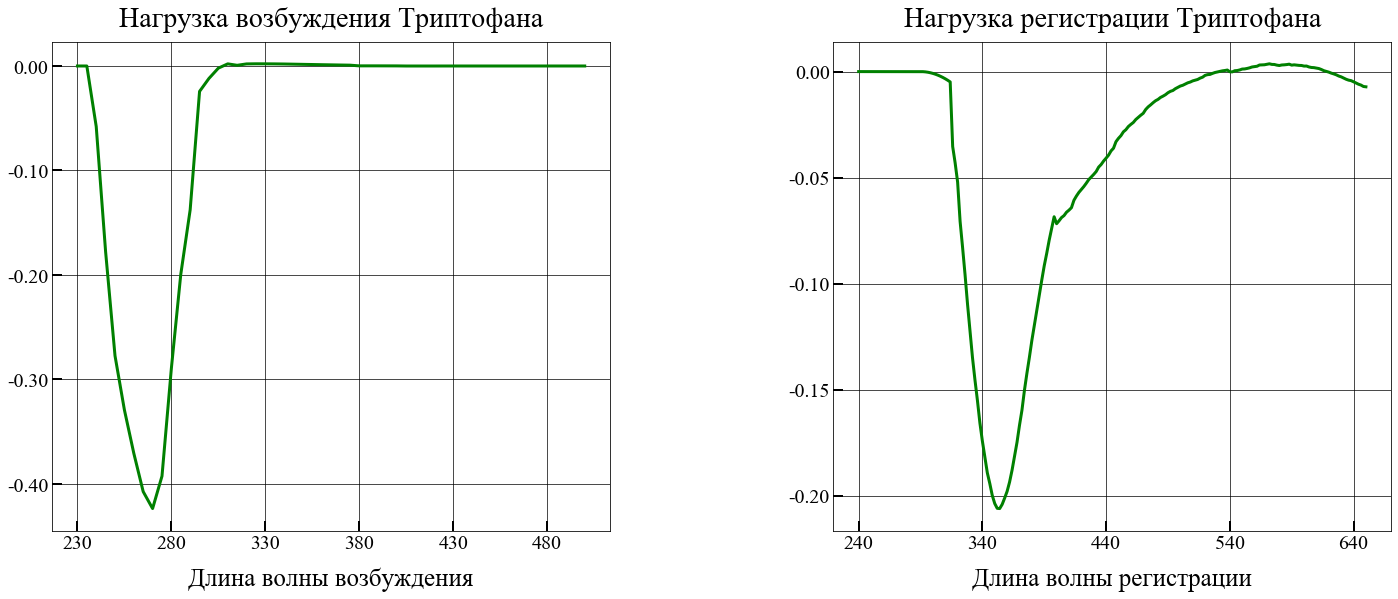

In [61]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(24, 9),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.4, hspace=0.45)

fig_ax_1 = fg.add_subplot(gs[0,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,0],"-",color="green",lw=3,label="1-st")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Нагрузка возбуждения Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels(range(180,545,50), fontsize=20)
fig_ax_1.set_yticklabels(['0','-0.40','-0.30','-0.20','-0.10','0.00','0.10','0.20','0.1','0.2','0.3','0.4'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран




fig_ax_2 = fg.add_subplot(gs[0, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,0],"-",color="green",lw=3,label="1-st")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Нагрузка регистрации Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['5','-0.20','-0.15','-0.10','-0.05','0.00','0.05','0.10','0.2','1.0','9'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран




plt.savefig('Trp_N-PLS1_loading_1_component.png', format='png', dpi=300)
plt.savefig("Trp_N-PLS1_loading_1_component.svg", format="svg")

plt.show();

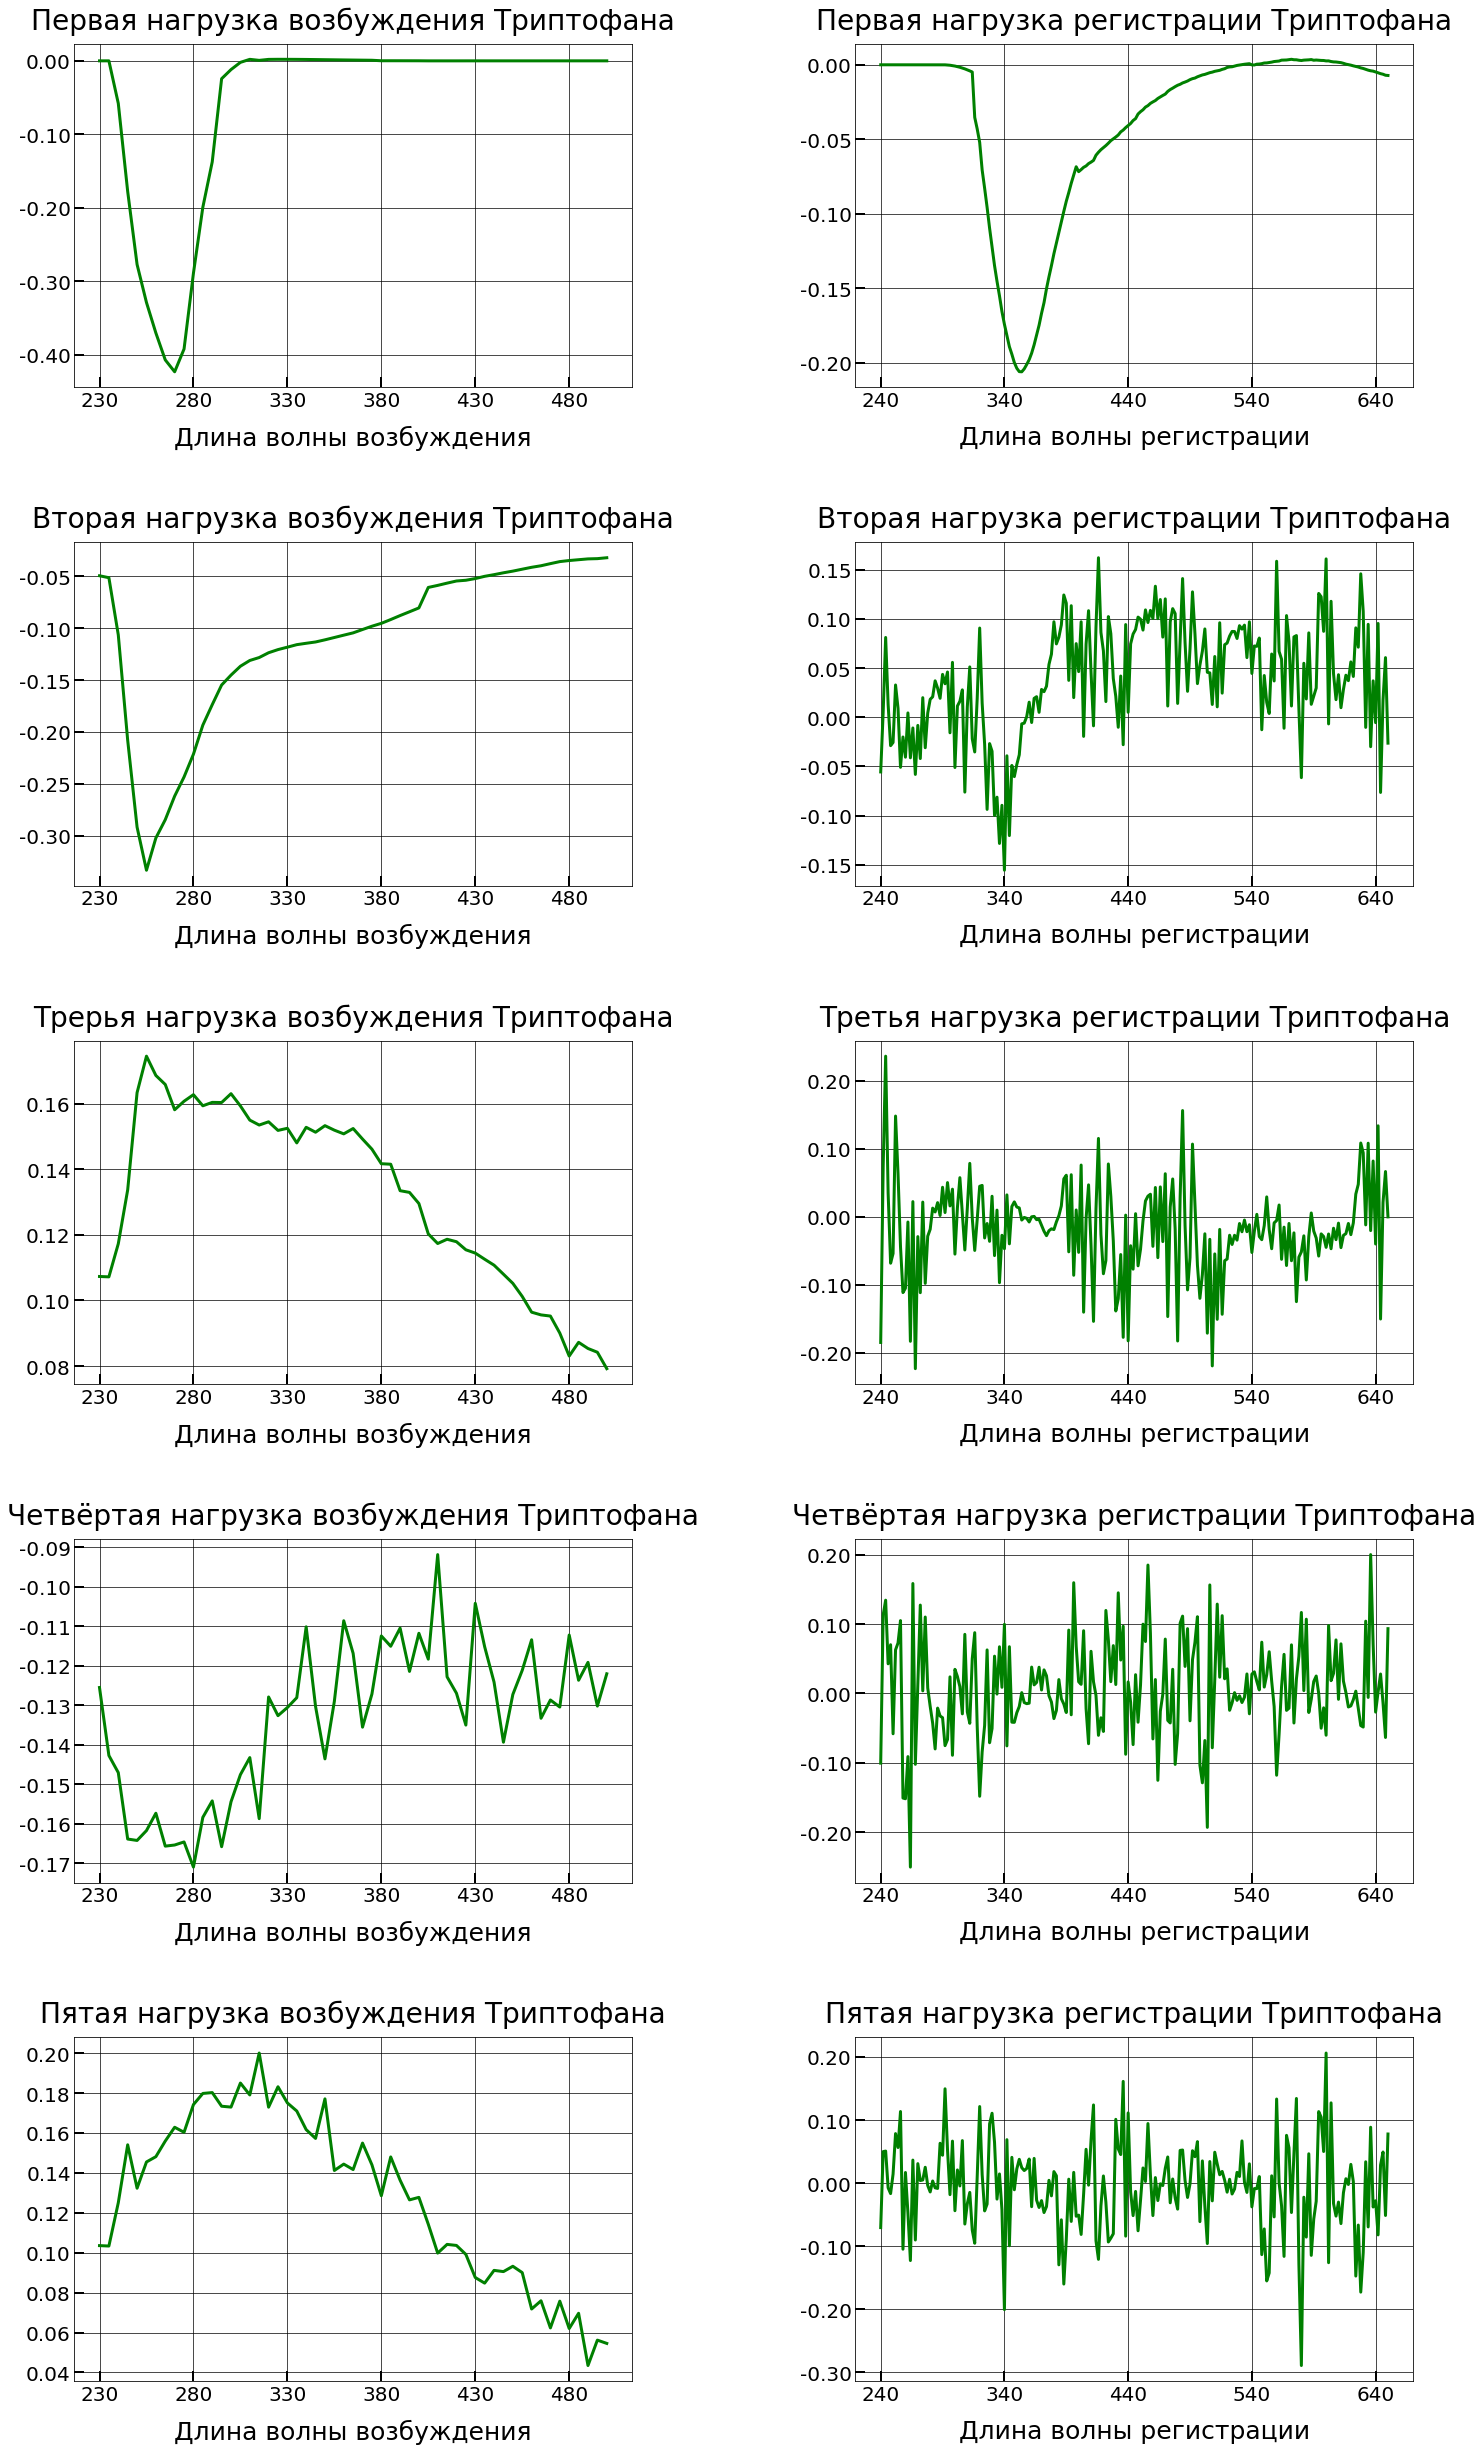

In [34]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(24, 43),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=5, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.4, hspace=0.45)

fig_ax_1 = fg.add_subplot(gs[0,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,0],"-",color="green",lw=3,label="1-st")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Первая нагрузка возбуждения Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels(range(180,545,50), fontsize=20)
fig_ax_1.set_yticklabels(['0','-0.40','-0.30','-0.20','-0.10','0.00','0.10','0.20','0.1','0.2','0.3','0.4'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран

fig_ax_1 = fg.add_subplot(gs[1,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,1],"-",color="green",lw=3,label="2-nd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Вторая нагрузка возбуждения Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels(range(180,545,50), fontsize=20)
fig_ax_1.set_yticklabels(['0','-0.30','-0.25','-0.20','-0.15','-0.10','-0.05','0.50','0.4'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран

fig_ax_1 = fg.add_subplot(gs[2,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,2],"-",color="green",lw=3,label="3-rd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Трерья нагрузка возбуждения Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels(range(180,545,50), fontsize=20)
fig_ax_1.set_yticklabels(['0.06','0.08','0.10','0.12','0.14','0.16','0.18','0.20','0.22','0.4'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран

fig_ax_1 = fg.add_subplot(gs[3,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,3],"-",color="green",lw=3,label="4-th")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Четвёртая нагрузка возбуждения Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels(range(180,545,50), fontsize=20)
fig_ax_1.set_yticklabels(['-0.5','-0.17','-0.16','-0.15','-0.14','-0.13','-0.12','-0.11','-0.10','-0.09','0.3','0.4'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран



fig_ax_1 = fg.add_subplot(gs[4,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,4],"-",color="green",lw=3,label="5-th")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Пятая нагрузка возбуждения Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels(range(180,545,50), fontsize=20)
fig_ax_1.set_yticklabels(['0.0','0.04','0.06','0.08','0.10','0.12','0.14','0.16','0.18','0.20','0.22'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')

#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран





fig_ax_2 = fg.add_subplot(gs[0, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,0],"-",color="green",lw=3,label="1-st")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Первая нагрузка регистрации Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['5','-0.20','-0.15','-0.10','-0.05','0.00','0.05','0.10','0.2','1.0','9'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран


fig_ax_2 = fg.add_subplot(gs[1, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,1],"-",color="green",lw=3,label="2-nd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Вторая нагрузка регистрации Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['-0.20','-0.15','-0.10','-0.05','0.00','0.05','0.10','0.15','1.0','9'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран


fig_ax_2 = fg.add_subplot(gs[2, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,2],"-",color="green",lw=3,label="3-rd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Третья нагрузка регистрации Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['-0.30','-0.20','-0.10','0.00','0.10','0.20','1.0','9'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран



fig_ax_2 = fg.add_subplot(gs[3, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,3],"-",color="green",lw=3,label="4-th")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Четвёртая нагрузка регистрации Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['5','-0.20','-0.10','0.00','0.10','0.20','0.15','1.0','9'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран



fig_ax_2 = fg.add_subplot(gs[4, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,4],"-",color="green",lw=3,label="5-th")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Пятая нагрузка регистрации Триптофана", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['5','-0.30','-0.20','-0.10','0.00','0.10','0.20','1.0','9'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран






#plt.savefig('Trp_N-PLS1_loading.png', format='png', dpi=300)
#plt.savefig("Trp_N-PLS1_loading.svg", format="svg")

plt.show();

In [68]:
Xdata_numpy['emission'][0]

240

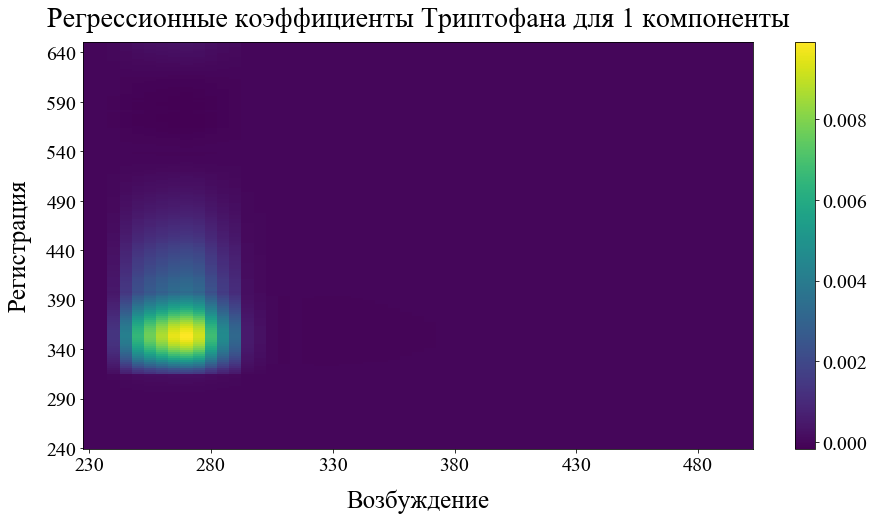

In [62]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(15, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0, hspace=0)

fig_ax_1 = fg.add_subplot(gs[0])
plt.imshow(b_npls1_full,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Регрессионные коэффициенты Триптофана для 1 компоненты",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(180,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)
plt.savefig('Trp_b_npls1_full.png', format='png', dpi=300)
plt.savefig("Trp_b_npls1_full.svg", format="svg")

plt.show();

### Определю ка я число волн emission в цикле, а то 7 плохо на Гуминах работает

In [18]:
new_r2_p=list()
new_r2_cv=list()
new_r2_c=list()
nmt=list()

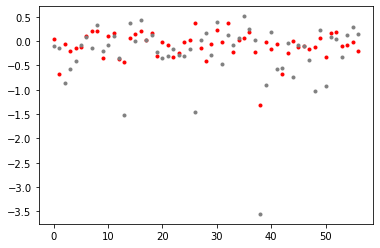

In [19]:
new_r2_p=list()
new_r2_cv=list()
new_r2_c=list()
nmt=list()
for j in range(2,5):
    for i in range(2,21):
        select=variable_class(number_variable_emission=i, number_variable_excitation=j)
        select.finding_variable(b_npls1_full)
        x_new=select.transform(Xdata_numpy['X'])
        new_cen=centrir(testSize=0.1428,column_y=0)
        new_result=new_cen.centering_and_cv(x_new,Ydata)
        y_train=new_result.y_train
        y_test=new_result.y_test
        X_train=new_result.X_train
        X_test=new_result.X_test
        new_npls1=Tri_PLS1_grid()
        parametrsNames={'n_components': range(1,3)}
        new_gridCought=GridSearchCV(new_npls1, parametrsNames, cv=5,return_train_score=True)
        new_gridCought.fit(X_train.copy(),y_train.copy())
        new_r2_p+=[new_gridCought.score(X_test.copy(), y_test.copy())]
        new_r2_cv+=[max(new_gridCought.cv_results_[ "mean_test_score" ])]
        new_r2_c+=[max(new_gridCought.cv_results_[ "mean_train_score" ])]
        nmt+=[0.5*(new_gridCought.score(X_test.copy(), y_test.copy())+max(new_gridCought.cv_results_[ "mean_test_score" ]))]
plt.plot(new_r2_cv,".", color="red")
plt.plot(nmt,".", color="grey")
plt.show()

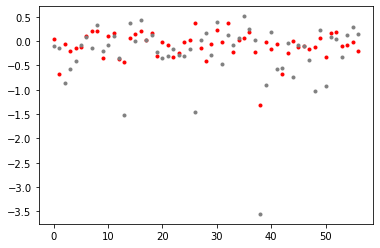

In [20]:
#plt.plot(new_r2_p,".", color="green")
#plt.plot(new_r2_c, ".", color="blue")
plt.plot(new_r2_cv,".", color="red")
plt.plot(nmt,".", color="grey")
plt.show()

In [21]:
max(nmt)

0.5085604015325503

In [22]:
max(new_r2_cv)

0.37672262865876777

In [23]:
mma=nmt

In [24]:
n_r2_cv_prr=new_r2_cv

In [25]:
len(n_r2_cv_prr)/3

19.0

In [26]:
print(new_r2_cv[13],new_r2_p[13])

-0.4332409882501447 -2.623543831124521


In [27]:
14 0.42726841144390604

SyntaxError: invalid syntax (<ipython-input-27-dd6ccfa87805>, line 1)

In [28]:
r2_cv_pr=new_r2_cv
r2_p_pr=new_r2_p

In [29]:
print(r2_cv_pr[13],r2_p_pr[13])

-0.4332409882501447 -2.623543831124521


#### Построю ка график в зависимости от число длин волн r2

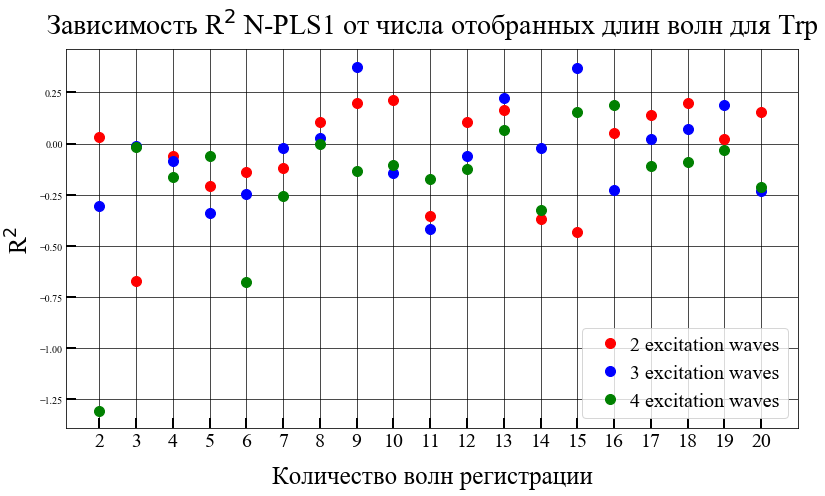

In [30]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(n_r2_cv_prr[:19],".",color="red",ms=20,label='2 excitation waves')
axs.plot(n_r2_cv_prr[19:38],".",color="blue",ms=20,label='3 excitation waves')
axs.plot(n_r2_cv_prr[38:57],".",color="green",ms=20,label='4 excitation waves')

axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))

axs.set_ylabel('R$^{2}$',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество волн регистрации",  fontsize=25,labelpad=15)
axs.set_title("Зависимость R$^{2}$ N-PLS1 от числа отобранных длин волн для Trp", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(2,21,1), fontsize=20)
#axs.set_yticklabels(['0','-0.75','-0.50','-0.25','0.00','0.25',
#                     '0.50','0.75','0.20','0.30','0.40','0.50','0.60','0.70'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=4,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

#plt.savefig('N-PLS1 Tyr с использованием числа отобранных длин волн для Trp.png', format='png', dpi=300)
#plt.savefig("N-PLS1 Tyr с использованием числа отобранных длин волн для Trp.svg", format="svg")


plt.show();

##### Для Гуминов мне приглянулись 2 точки: 2 excit. 9 emission and 4 excit. 16 emiss.

In [645]:
mma[7]

-1.44546081556455

In [646]:
mma[13]

-0.21164932246441437

In [824]:
pkl.dump(
	{'r2_cv': n_r2_cv_prr, 'r2_p': mma},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_number_wave_emission_excitation.pkl.gz', 'wb')
)

### Теперь произведём отбор переменных из исходных данных, чтобы потом заново центрировать и обучить новую модель

In [929]:
select=variable_class(number_variable_emission=7, number_variable_excitation=3)
select.finding_variable(b_npls1_full)

In [930]:
x_new=select.transform(Xdata_numpy['X'])

### Заново центрируем новые данные

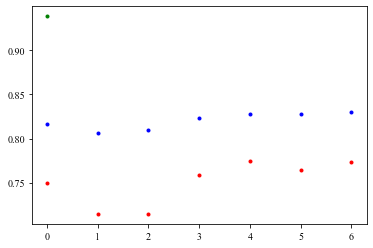

In [931]:
new_r2_cv=[0,0]
new_cen=centrir(testSize=0.1428,column_y=2)
new_result=new_cen.centering_and_cv(x_new,Ydata)
y_train=new_result.y_train
y_test=new_result.y_test
X_train=new_result.X_train
X_test=new_result.X_test
new_npls1=Tri_PLS1_grid()
parametrsNames={'n_components': range(1,8)}
new_gridCought=GridSearchCV(new_npls1, parametrsNames, cv=5,return_train_score=True)
new_gridCought.fit(X_train.copy(),y_train.copy())
new_r2_p=new_gridCought.score(X_test.copy(), y_test.copy())
new_r2_cv=new_gridCought.cv_results_[ "mean_test_score" ]
new_r2_c=new_gridCought.cv_results_[ "mean_train_score" ]
new_predictors=new_gridCought.predict(X_test.copy())
plt.plot(new_r2_p,".", color="green")
plt.plot(new_r2_c, ".", color="blue")
plt.plot(new_r2_cv,".", color="red")
plt.show()

In [932]:
new_r2_p

0.9386911702249452

In [290]:
new_result=new_cen.centering_and_cv(x_new,Ydata)

In [291]:
y_train=new_result.y_train
y_test=new_result.y_test
X_train=new_result.X_train
X_test=new_result.X_test

### Снова делаем обучение по всем компонентам, но уже на новых данных

In [292]:
new_npls1=Tri_PLS1_grid()
parametrsNames={'n_components': range(1,8)}

In [293]:
%%time
new_gridCought=GridSearchCV(new_npls1, parametrsNames, cv=5,return_train_score=True)
new_gridCought.fit(X_train.copy(),y_train.copy())
new_r2_p=new_gridCought.score(X_test.copy(), y_test.copy())
new_r2_cv=new_gridCought.cv_results_[ "mean_test_score" ]
new_r2_c=new_gridCought.cv_results_[ "mean_train_score" ]
new_predictors=new_gridCought.predict(X_test.copy())

Wall time: 214 ms


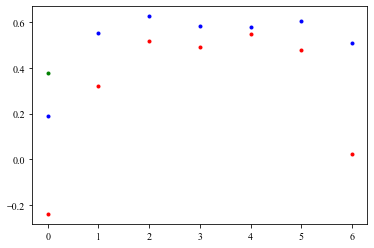

In [529]:
plt.plot(new_r2_p,".", color="green")
plt.plot(new_r2_c, ".", color="blue")
plt.plot(new_r2_cv,".", color="red")
plt.show()

In [933]:
b_npls1_small=new_gridCought.best_estimator_.b.reshape(7,3)

In [934]:
b_npls1_small

array([[ 1.18793675,  1.43212358,  0.56367563],
       [-0.22889696, -0.37208574, -0.71624092],
       [-0.1771388 , -0.32420899, -0.16310932],
       [-0.22723987, -0.0176538 , -0.49612528],
       [-0.38626498,  0.41808796,  0.30527622],
       [-0.54427213,  0.19810908, -0.02808255],
       [-0.43224991,  0.48546586, -0.08742599]])

In [935]:
new_gridCought.best_estimator_

Tri_PLS1_grid(n_components=5)

In [936]:
select.emission_vave_lenth(Xdata_numpy['emission'])

array([376., 466., 474., 492., 504., 570., 632.])

In [937]:
select.excitation_vave_lenth(Xdata_numpy['excitation'])

array([260., 265., 270.])

In [535]:
[318., 354., 362., 370., 378., 452., 458., 474., 488.]

[318.0, 354.0, 362.0, 370.0, 378.0, 452.0, 458.0, 474.0, 488.0]

In [536]:
[250., 255.]

[250.0, 255.0]

In [948]:
pkl.dump(
	{'r2_cv': new_r2_cv, 'r2_c': new_r2_c, 'r2_p': new_r2_p, 'predict':new_predictors,'y_test':y_test,
     'parametrs':gridCought.best_params_, 'True_predictors':n_predictors, 'True_y':yTest,
     'X_test':X_test,'X_train':X_train,'y_train':y_train, 'b_npls1_v-s':b_npls1_small, 
     'emission_vale_lendth':select.emission_vave_lenth(Xdata_numpy['emission']),
     'excitation_vale_lendth':select.excitation_vave_lenth(Xdata_numpy['excitation']),
     'b_npls1_without_v-s':b_npls1_full},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/Gominy_N-PLS1_final_with_variable_selection_7_3.pkl.gz', 'wb')
)

In [5]:
r=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Gominy_N-PLS1_final_with_variable_selection_14_2.pkl.gz', 'rb'))['b_npls1_without_v-s']

In [6]:
max(r)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [7]:
r

array([[ 5.94974443e-05, -9.39291459e-06, -5.33079404e-03, ...,
        -2.29473635e-05,  5.86624633e-05, -2.32035859e-05],
       [ 1.12405272e-04, -1.77441548e-05, -6.72535274e-03, ...,
        -4.30682286e-05,  1.10819486e-04, -4.38339840e-05],
       [-5.53331567e-04,  8.73489288e-05,  3.48308487e-02, ...,
         2.12156585e-04, -5.45529581e-04,  2.15780958e-04],
       ...,
       [-1.47364841e-04,  2.33262946e-05,  1.64301105e-01, ...,
         6.97059895e-05, -1.45671637e-04,  5.76195435e-05],
       [ 4.77280034e-03, -7.53490193e-04, -4.37298719e-01, ...,
        -1.84162847e-03,  4.70584335e-03, -1.86136814e-03],
       [ 2.25272949e-03, -3.55671943e-04, -2.79082255e-01, ...,
        -8.75426537e-04,  2.22130657e-03, -8.78624507e-04]])

In [155]:
r

array([318., 350., 352., 358., 362., 364., 366., 378., 462.])

In [20]:
b_npls1_full_humic=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Gominy_N-PLS1_final_with_variable_selection_9_2.pkl.gz', 'rb'))['b_npls1_without_v-s']
b_npls1_full_Tyr=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Tyr_N-PLS1_final_with_variable_selection_9_2.pkl.gz', 'rb'))['b_npls1_without_v-s']
b_npls1_full_Trp=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_with_variable_selection_6_2.pkl.gz', 'rb'))['b_npls1_without_v-s']

In [21]:
select=variable_class(number_variable_emission=6, number_variable_excitation=2)
select.finding_variable(b_npls1_full_Trp)

In [22]:
x_new=select.transform(Xdata_numpy['X'])

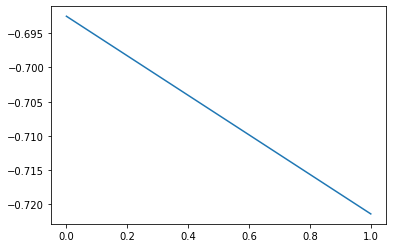

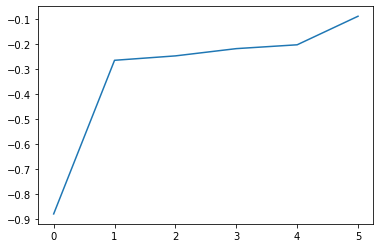

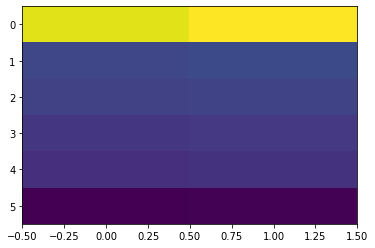

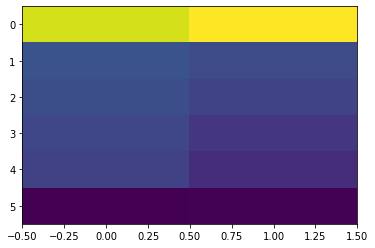

In [29]:
# для гуминовых веществ может иметь смысл взять чуть больше компонент;
# для аминокислот должно быть достаточно одного
model = Tri_PLS1_grid(n_components=1)

# NB: здесь мы ничего не центрируем, что как будто не влияет на результат
X = x_new
#X -= X.mean(axis = 0) # раскомментировать для центрирования по X

y0 = Ydata.to_numpy()[:,2] # здесь номер колонки выбирает гуминовые вещества / тирозин / триптофан
#y0 -= y0.mean() # раскомментировать для центрирования по y
model.fit(X, y0)

# почему-то массивы w_i, w_k оказываются трёхмерными, но последняя размерность всегда 1
# уберём её, чтобы работать, как мы обычно работаем с матрицами
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])

plt.figure()
plt.plot(flatten(model.w_i).transpose())

plt.figure()
plt.plot(flatten(model.w_k).transpose())

plt.figure()
plt.imshow(np.kron(model.w_k[0,:],model.w_i[0,:]).reshape([6,2]),aspect='auto')

plt.figure()
plt.imshow(x_new[1,:,:],aspect='auto')

In [235]:
a=[[1, 0, 0, 0, 2],[0, 0, 3, 0, 0],[1,2,3,4,5]]

In [236]:
a

[[1, 0, 0, 0, 2], [0, 0, 3, 0, 0], [1, 2, 3, 4, 5]]

In [237]:
np.linalg.svd(a,full_matrices=False)

(array([[-0.19700962,  0.3485789 , -0.91634053],
        [-0.17411839, -0.93224018, -0.31719241],
        [-0.96481604,  0.09706178,  0.24435428]]),
 array([7.67270131, 2.83953334, 1.43760389]),
 array([[-0.15142329, -0.25149318, -0.44531947, -0.50298637, -0.68008635],
        [ 0.15694152,  0.0683646 , -0.8823757 ,  0.1367292 ,  0.41642994],
        [-0.46743491,  0.33994661, -0.15199901,  0.67989322, -0.4249499 ]]))

In [147]:
emis=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_with_variable_selection_6_2.pkl.gz', 'rb'))['emission_vale_lendth']
exci=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_with_variable_selection_6_2.pkl.gz', 'rb'))['excitation_vale_lendth']

In [155]:
exci

[260, 265, 260, 265]

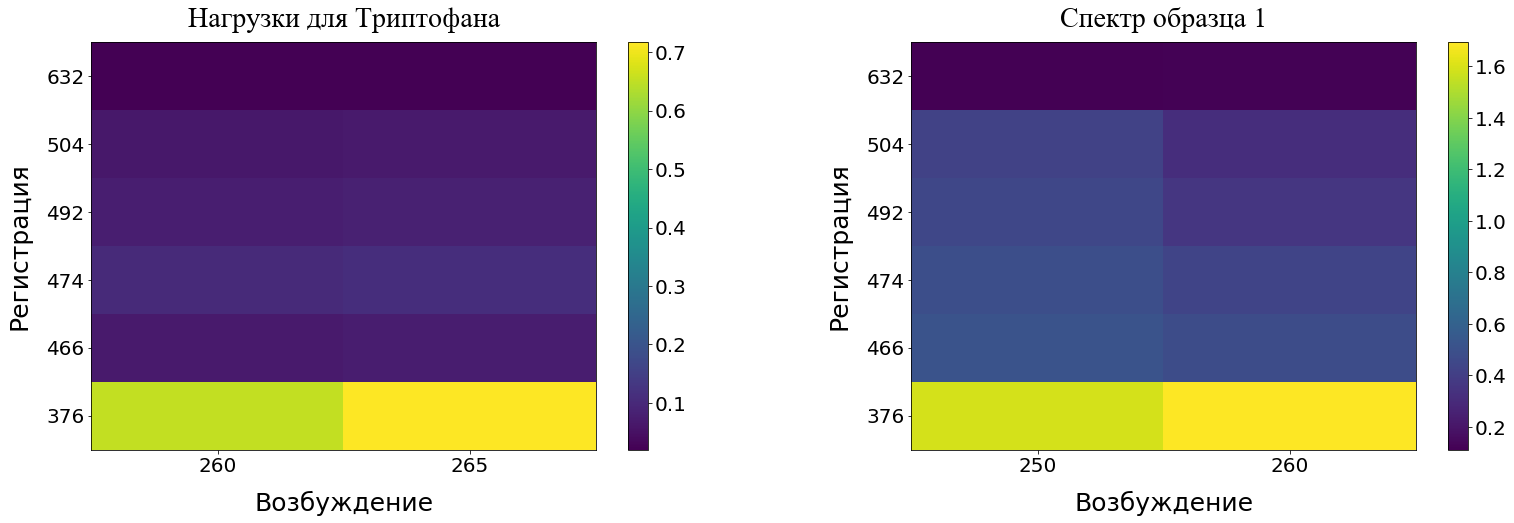

In [158]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(26, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

fig_ax_1 = fg.add_subplot(gs[0])
plt.imshow(np.kron(model.w_k[0,:],model.w_i[0,:]).reshape([6,2]),aspect="auto", origin='lower')
fig_ax_1.set_xticks(range(0,2,1))
fig_ax_1.set_yticks(range(0,6,1))
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Нагрузки для Триптофана",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(emis, fontsize=20)
fig_ax_1.set_xticklabels(exci, fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_2 = fg.add_subplot(gs[1])
plt.imshow(x_new[1,:,:],aspect="auto", origin='lower')
fig_ax_2.set_xticks(range(0,2,1)) # Задаём места, где будет сетка и метки по оси ох
fig_ax_1.set_yticks(range(0,6,1))
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Спектр образца 1",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_2.set_yticklabels([1,376,466,474,492,504,632,2], fontsize=20)
fig_ax_2.set_xticklabels([250, 260, 265,6], fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.savefig('Trp_loadings_6_2.png', format='png', dpi=300)
plt.savefig("Trp_loadings_6_2.svg", format="svg")
plt.show();

In [30]:
select=variable_class(number_variable_emission=206, number_variable_excitation=3)
select.finding_variable(b_npls1_full_humic)

In [31]:
b_npls1_full_humic_col=select.transform(b_npls1_full_humic.reshape(1,206,55))

In [32]:
excitation_vale_lendth=select.excitation_vave_lenth(Xdata_numpy['excitation'])

In [33]:
select1=variable_class(number_variable_emission=4, number_variable_excitation=3)
select1.finding_variable(b_npls1_full_humic_col.reshape(206,3))

In [35]:
b_npls1_full_humic_col_row=select1.transform(b_npls1_full_humic_col.reshape(1,206,3))

In [36]:
emission_vale_lendth=select1.emission_vave_lenth(Xdata_numpy['emission'])

In [37]:
excitation_vale_lendth

array([250., 255., 260.])

In [38]:
emission_vale_lendth

array([318., 362., 378., 474.])

In [39]:
b_npls1_full_humic_col_row

array([[[-8.81057658, -8.7175995 , -7.68044725],
        [ 3.22279153,  3.38118076,  3.19677667],
        [-3.54151499, -3.71294009, -3.53612209],
        [ 3.30281856,  3.52102314,  2.78299893]]])

In [ ]:
b_npls1_full_humic

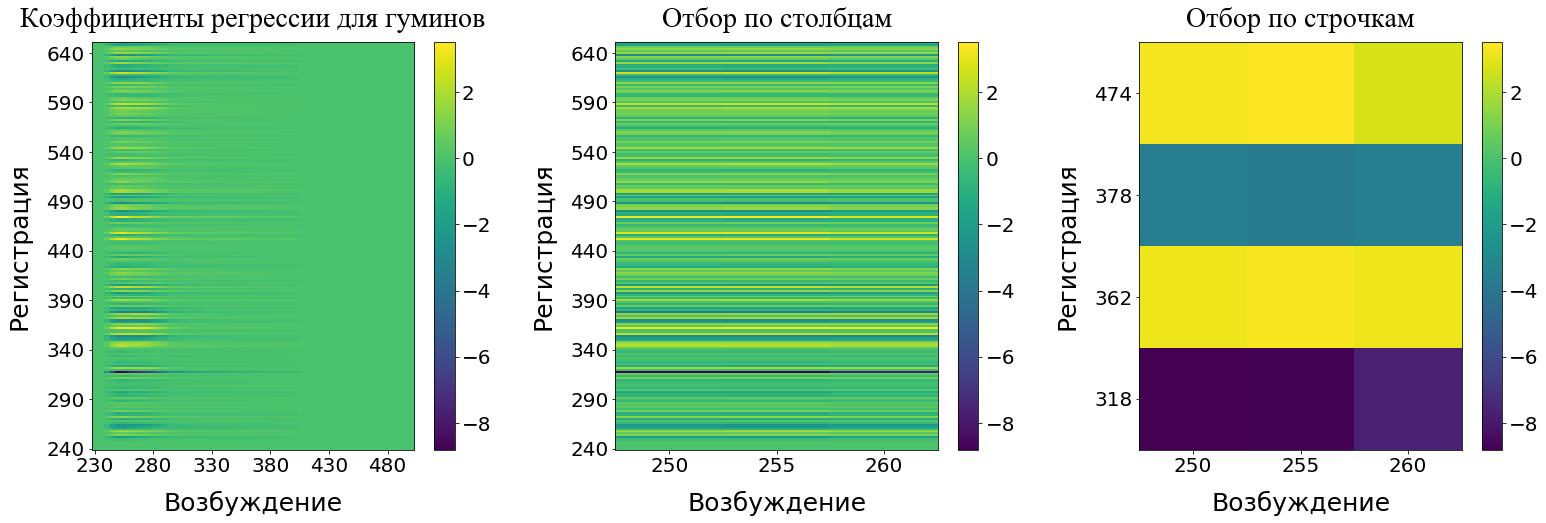

In [51]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(26, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

fig_ax_1 = fg.add_subplot(gs[0])
plt.imshow(b_npls1_full_humic,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Коэффициенты регрессии для гуминов",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(180,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_2 = fg.add_subplot(gs[1])
plt.imshow(b_npls1_full_humic_col.reshape(206,3),aspect="auto", origin='lower')
fig_ax_2.set_xticks(range(0,3,1)) # Задаём места, где будет сетка и метки по оси ох
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Отбор по столбцам",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_2.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_2.set_xticklabels([250, 255, 260], fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_3 = fg.add_subplot(gs[2])
plt.imshow(b_npls1_full_humic_col_row.reshape(4,3),aspect="auto", origin='lower')
fig_ax_3.set_xticks(range(0,3,1))
fig_ax_3.set_yticks(range(0,4,1))
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Отбор по строчкам",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_3.set_yticklabels([318, 362, 378, 474], fontsize=20)
fig_ax_3.set_xticklabels([250, 255, 260], fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.savefig('Отбор длин волн мой.png', format='png', dpi=300)
plt.savefig("Отбор длин волн мой.svg", format="svg")

plt.show();

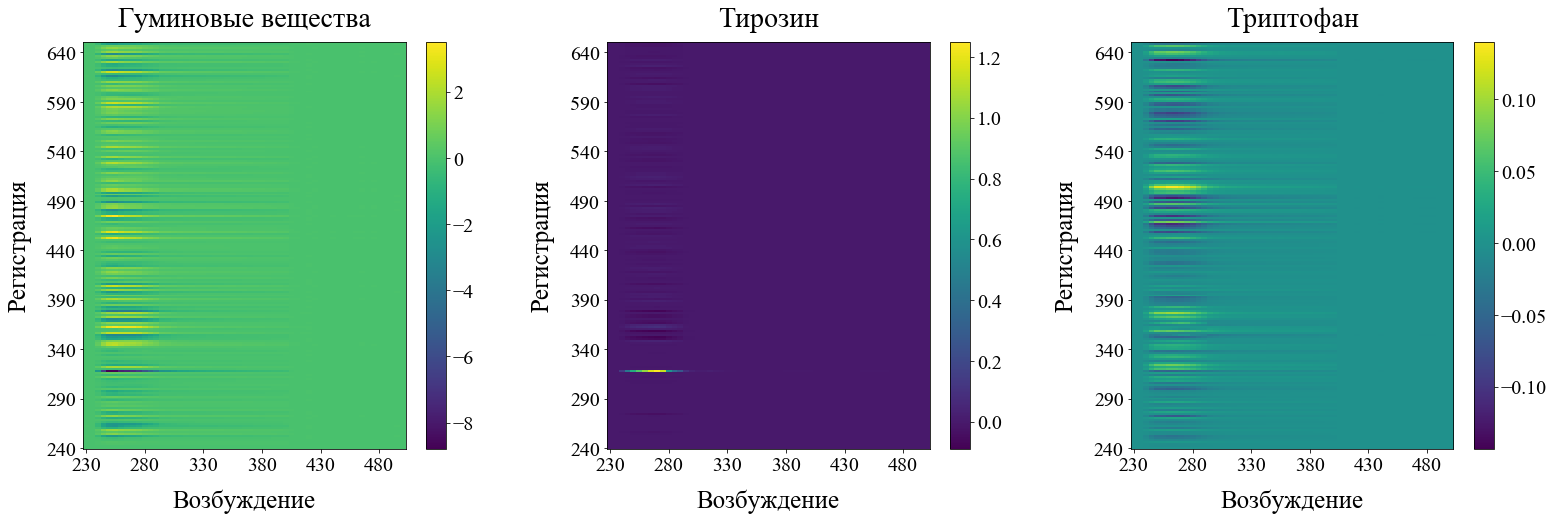

In [95]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(26, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

fig_ax_1 = fg.add_subplot(gs[0])
plt.imshow(b_npls1_full_humic,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Гуминовые вещества",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(180,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_2 = fg.add_subplot(gs[1])
plt.imshow(b_npls1_full_Tyr,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Тирозин",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_2.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_2.set_xticklabels(range(180,520,50), fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_3 = fg.add_subplot(gs[2])
plt.imshow(b_npls1_full_Trp,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Триптофан",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_3.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_3.set_xticklabels(range(180,520,50), fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.savefig('Регрессионные коэффициенты.png', format='png', dpi=300)
plt.savefig("Регрессионные коэффициенты.svg", format="svg")

plt.show();

In [124]:
r2_cv=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Tyr_N-PLS1_final.pkl.gz', 'rb'))['r2_cv']
r2_c=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Tyr_N-PLS1_final.pkl.gz', 'rb'))['r2_c']
r2_p=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Tyr_N-PLS1_final.pkl.gz', 'rb'))['r2_p']

In [182]:
min(mse_cv**0.5)

4.047285843348167

In [180]:
max(r2_cv)

0.7528528022242108

# Строю R2 по новому

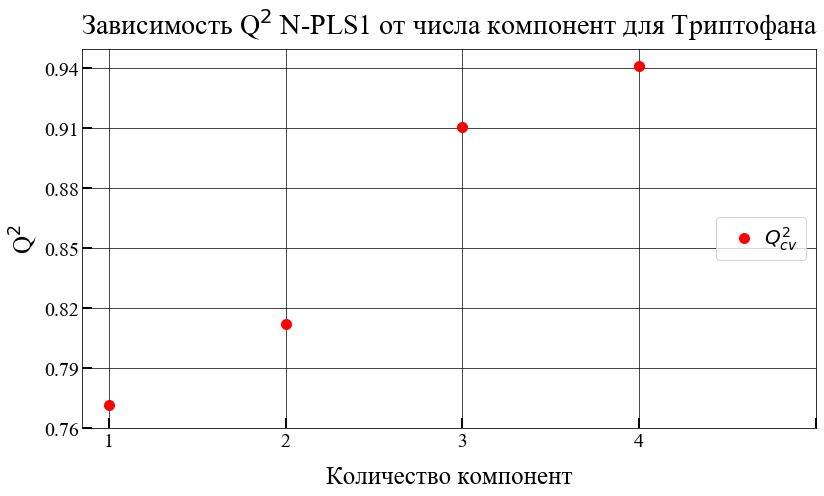

In [321]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(r2_cv[:-1],".",color="red",ms=20,label='$Q_{cv}^{2}$')
#axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
#axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')

axs.set_xticks(range(0,5,1)) # Задаём места, где будет сетка и метки по оси ох
axs.set_yticks(np.linspace(0.76,0.94,7))

axs.set_ylabel('Q$^{2}$',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество компонент",  fontsize=25,labelpad=15)
axs.set_title("Зависимость Q$^{2}$ N-PLS1 от числа компонент для Триптофана", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,5,1), fontsize=20)
axs.set_yticklabels(['0.76','0.79','0.82','0.85','0.88','0.91','0.94','0.50','0.60','0.70','0.80','1.00'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=7,fontsize=20, markerscale=1,handletextpad=0)

#axs.set_xlim(xmax=20) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1_Trp_Q.png', format='png', dpi=300)
plt.savefig("N-PLS1_Trp_Q.svg", format="svg")


plt.show();

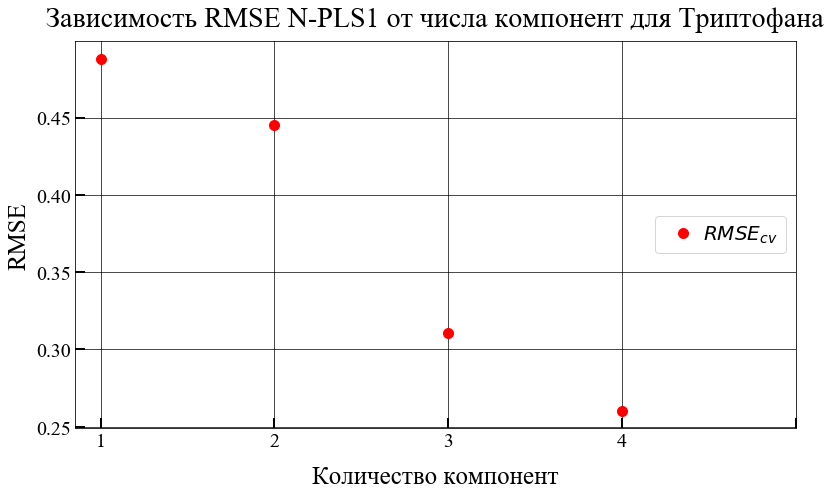

In [325]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(mse_cv[:-1]**0.5,".",color="red",ms=20,label='$RMSE_{cv}$')
#axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
#axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')

axs.set_xticks(range(0,5,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(0.47,0.68,num=8))

axs.set_ylabel('RMSE',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество компонент",  fontsize=25,labelpad=15)
axs.set_title("Зависимость RMSE N-PLS1 от числа компонент для Триптофана", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,5,1), fontsize=20)
axs.set_yticklabels(['u','0.25','0.30','0.35','0.40','0.45','6.50','7.00','7.50','8.00'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=7,fontsize=20, markerscale=1,handletextpad=0)

#axs.set_xlim(xmax=20) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1_Trp_RMSE.png', format='png', dpi=300)
plt.savefig("N-PLS1_Trp_RMSE.svg", format="svg")


plt.show();

# Строю введено-найдено по новому

In [68]:
yTest=y_test+result.medium

In [69]:
y_test

array([-0.0919573 , -1.65809917,  1.50618408,  1.64538909, -0.3100686 ])

In [70]:
yTest

array([2.4133796 , 0.84723773, 4.01152098, 4.15072599, 2.1952683 ])

In [71]:
n_predictors=predictors+result.medium

In [72]:
n_predictors

array([2.61458975, 1.26815141, 3.20737412, 4.4109368 , 2.30298534])

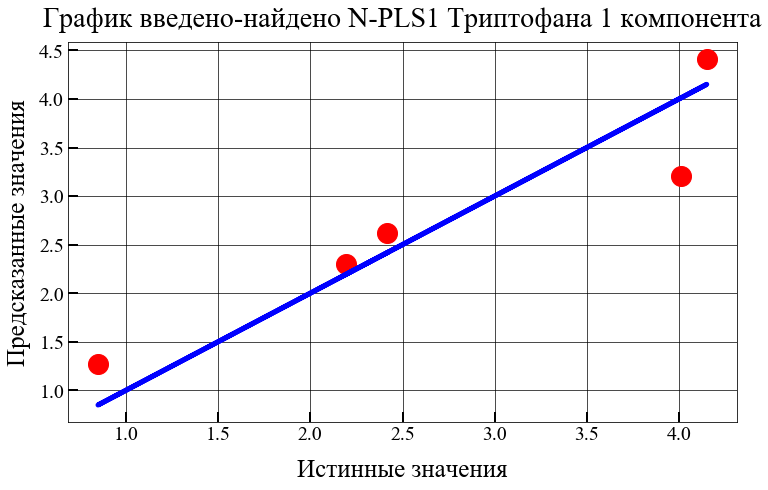

In [75]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(yTest,n_predictors,".",color="red",ms=40)
axs.plot(yTest,yTest,color="blue",lw=5)
#axs.set_yticks(np.linspace(1.0, 4.5, num = 8))
axs.set_ylabel("Предсказанные значения" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("Истинные значения",  fontsize=25,labelpad=15)
axs.set_title("График введено-найдено N-PLS1 Триптофана 1 компонента", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels(['15','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','60'], fontsize=20)
axs.set_yticklabels(['15','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','60'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
plt.savefig('График введено-найдено N-PLS1 Trp 1 component.png', format='png', dpi=300)
plt.savefig("График введено-найдено N-PLS1 Trp 1 component.svg", format="svg")
plt.show();

# Сохраним абсолютно всё в пикль, потому что считать заново - это очень долго.

In [76]:
pkl.dump(
	{'r2_cv': r2_cv, 'r2_c': r2_c, 'r2_p': r2_p, 'predict':predictors,'y_test':y_test,
     'parametrs':gridCought.best_params_, 'True_predictors':n_predictors, 'True_y':yTest,
     'X_test':X_test,'X_train':X_train,'y_train':y_train, 'b_npls1_without_w-s':b_npls1_full,
     'w_i_best_estimator':gridCought.best_estimator_.w_i,'w_k_best_estimator':gridCought.best_estimator_.w_k},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_1_component.pkl.gz', 'wb')
)